# LogisticRegression

## Import and Load Data Set

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import RFE
from verstack.stratified_continuous_split import scsplit 
from datetime import datetime
from pandas import DataFrame
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.decomposition as skdc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as sklm 
import sklearn.pipeline as skpl
import re
import matplotlib.pyplot as plt

In [22]:
# Load the training data
train_data = pd.read_csv("data/train.csv")
# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")
train_data.tail(3)

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
665774,665774,1588353174952,8,False,888,85,257,NaN,twitter.com/i/web/status/1…,NaN,"'Post it' pearls for Palliative, End of Life a..."
665775,665775,1588691378352,0,False,452,38,91,NaN,NaN,NaN,His facial expressions are kind of looking for...
665776,665776,1588432578764,0,False,590,184,238,NaN,NaN,NaN,We really can't wait.


## 2. Target Variable

In [23]:
#target variable -> 0 no retweet, 1 retweet
train_data.drop('retweet_count',axis=1)
train_data = train_data.assign(retweet_bin=(train_data['retweet_count'] > 0 ).astype(int))

In [24]:
train_data["retweet_bin"].describe()

count    665777.000000
mean          0.364948
std           0.481416
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: retweet_bin, dtype: float64

In [25]:
count_no_RT = len(train_data[train_data['retweet_bin']==0])
count_RT = len(train_data[train_data['retweet_bin']==1])
pct_of_no_RT = count_no_RT/(count_no_RT+count_RT)
print("percentage of no click is", round(pct_of_no_RT*100))
pct_of_RT = count_RT/(count_no_RT+count_RT)
print("percentage of click is", round(pct_of_RT*100))

percentage of no click is 64
percentage of click is 36


* Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 63:46. Before we go ahead to balance the classes, let’s do some more exploration.

In [26]:
train_data.groupby('retweet_bin').mean()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count
retweet_bin,,,,,,,
0,332823.257449,1.588504e+12,0.000000,0.021637,32939.140042,6118.224076,1561.499812
1,333000.659564,1.588492e+12,404.680637,0.327591,56870.797143,627768.183106,4799.307728


First observation :<br>
* La moyenne des followers augmente quand notre tweet a ete RT
* La moyenne des amis augmente quand notre tweet a ete RT
* L'utilisateur a plus tendance a etre verifie lorsque son tweet a ete RT

## Random UnderSampling

total class of 1 and0: 1    242974
0    242974
Name: retweet_bin, dtype: int64


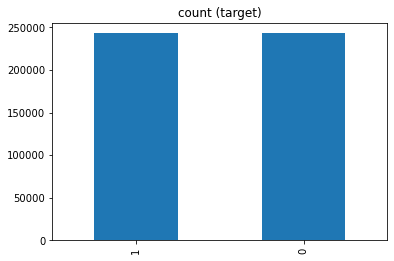

In [27]:
class_count_0, class_count_1 = train_data['retweet_bin'].value_counts()
class_0 = train_data[train_data['retweet_bin'] == 0]
class_1 = train_data[train_data['retweet_bin'] == 1]

class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and0:",test_under['retweet_bin'].value_counts())
# plot the count after under-sampeling
test_under['retweet_bin'].value_counts().plot(kind='bar', title='count (target)')

## Encode the object Value 

In [28]:
train_data.dtypes

id                       int64
timestamp                int64
retweet_count            int64
user_verified             bool
user_statuses_count      int64
user_followers_count     int64
user_friends_count       int64
user_mentions           object
urls                    object
hashtags                object
text                    object
retweet_bin              int64
dtype: object

In [29]:
# count the number of hashtag
train_data['totalhashtag'] = train_data['hashtags'].str.split().str.len()
train_data['totalhashtag'] = train_data['totalhashtag'].fillna(0)

In [30]:
labelencoder=LabelEncoder()
train_data['user_verified']=labelencoder.fit_transform(train_data['user_verified'])
# with hashtag --> 1, without --> 0
train_data['urls'] = train_data['urls'].fillna(0)
train_data = train_data.assign(urls=(train_data['urls'] !=0 ).astype(int))
# with user mentions --> 1, without--> 0
train_data['user_mentions'] = train_data['user_mentions'].fillna(0)
train_data = train_data.assign(user_mentions=(train_data['user_mentions']!= 0 ).astype(int))

## Correlation between features

In [31]:
train_data = train_data.drop(columns=['hashtags','text','timestamp'])

In [32]:
datacorr = train_data.corr()
datacorr.head()

,id,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,retweet_bin,totalhashtag
id,1.000000,0.001411,0.000932,0.000611,0.001433,0.002043,0.000685,0.000667,0.000444,0.001048
retweet_count,0.001411,1.000000,0.057923,0.001605,0.132853,0.025327,-0.001186,0.030485,0.065551,-0.001655
user_verified,0.000932,0.057923,1.000000,0.198346,0.235241,0.049641,0.119270,0.421360,0.433347,0.093272
user_statuses_count,0.000611,0.001605,0.198346,1.000000,0.172699,0.150665,-0.006830,0.115375,0.116983,-0.001115
user_followers_count,0.001433,0.132853,0.235241,0.172699,1.000000,0.060272,0.015888,0.114159,0.122539,0.001634


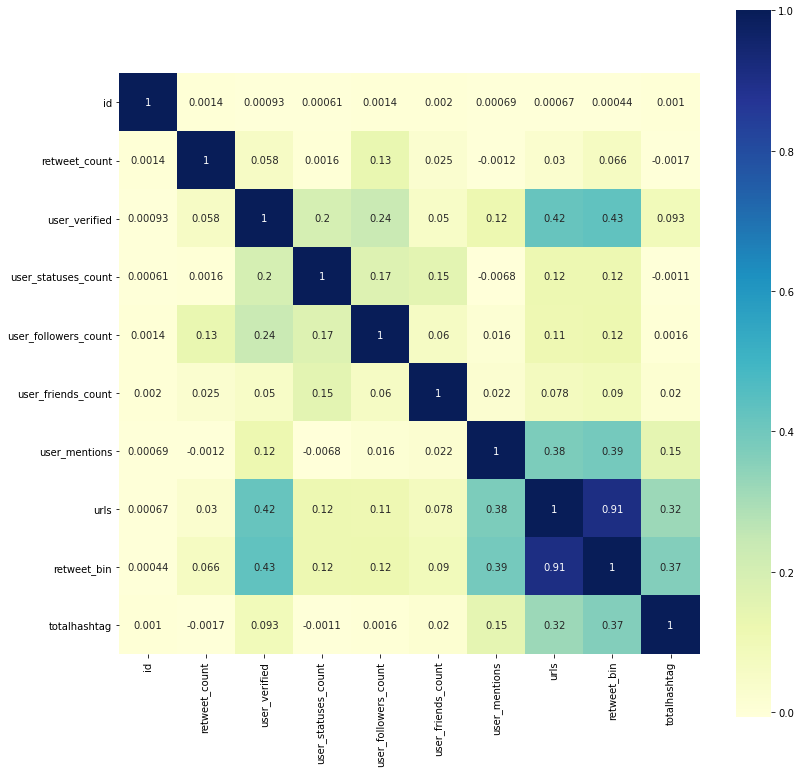

In [33]:
plt.figure(figsize = (13,13))
sns.heatmap(datacorr, cmap = 'YlGnBu',square=True,annot=True)

* the features that are highly correlated are the **number of followers**, **number of followees** and **number of statuses** and **user_verified** and also the **month** and if he puts **url**, which have a positive impact in the number of retweets

In [14]:
train_data.nunique()

id                      665777
user_verified                2
user_statuses_count     141785
user_followers_count     98958
user_friends_count       25170
user_mentions                2
urls                         2
retweet_bin                  2
totalhashtag                17
dtype: int64

In [15]:
train_data.isnull().sum()

id                      0
user_verified           0
user_statuses_count     0
user_followers_count    0
user_friends_count      0
user_mentions           0
urls                    0
retweet_bin             0
totalhashtag            0
dtype: int64

## Logistic Regression


In [16]:
y = train_data.retweet_bin 
X = train_data.drop("retweet_bin",axis=1)
X_train, X_test, y_train, y_test = scsplit(X, y, stratify=y, train_size=0.7,test_size=0.3)
train_data_model = LogisticRegression()
train_data_model_fit = train_data_model.fit(X_train,y_train)
y_pred=train_data_model_fit.predict(X_test)

In [17]:
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
results = pd.DataFrame([['Logistic Regression', acc,prec,rec,f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.732704,0.842734,0.328975,0.473221


In [18]:
print("Making predictions for the following 5 tweets:")
print(X.head())
print("The predictions are")
print(train_data_model_fit.predict(X.head()))

Making predictions for the following 5 tweets:
   id  user_verified  user_statuses_count  user_followers_count  \
0   0              0                68460                  1101   
1   1              0                  309                    51   
2   2              0                 3241                  1675   
3   3              0                32327                   667   
4   4              0                  581                    42   

   user_friends_count  user_mentions  urls  totalhashtag  
0                1226              0     0           0.0  
1                 202              0     0           0.0  
2                2325              0     0           0.0  
3                 304              0     0           0.0  
4                 127              0     0           0.0  
The predictions are
[0 1 1 0 1]


## Feature Selection

In [19]:
#Analyzing the coefficients
pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(train_data_model_fit.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,id,-1.903583e-06
1,user_verified,4.572585e-09
2,user_statuses_count,-2.306768e-06
3,user_followers_count,1.232688e-05
4,user_friends_count,3.142983e-05
5,user_mentions,7.695842e-09
6,urls,2.759791e-08
7,totalhashtag,1.811490e-08


In [20]:
rfe = RFE(train_data_model, 5)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
X_train.columns[rfe.support_]

[ True False  True  True  True False  True False]
[1 4 1 1 1 3 1 2]


Index(['id', 'user_statuses_count', 'user_followers_count',
       'user_friends_count', 'urls'],
      dtype='object')